In [1]:
!pip install highway_env -q
import gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import one_hot, softmax, normalize
from torch.distributions import Categorical
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from gym.wrappers.record_video import RecordVideo
from tqdm import tqdm
from time import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 34.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:

#FUNCTION FOR COMPUTING SMOOTH AVERAGE REWARD AND CONFIDENCE INTERVAL
def confidence_interval(rewards,window_size):
    from scipy.stats import t
    def moving_average(a, n):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    mean = np.mean(rewards,axis=0)
    std = np.std(rewards,axis=0) 
    smoothed_reward = moving_average(mean,window_size)
    N=rewards.shape[0]
    dof = N-1
    alpha=0.05

    t_crit = np.abs(t.ppf((alpha)/2,dof))
    upper_curve = (mean+std*t_crit/np.sqrt(N))
    lower_curve = (mean-std*t_crit/np.sqrt(N))


    return smoothed_reward,upper_curve,lower_curve

def plot_results(rewards,loss,window_size,epochs):
    mean,lower_curve,upper_curve =confidence_interval(np.array(rewards).reshape(-1,epochs),window_size)
    fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(16,8),tight_layout=True)
    plt.suptitle("Results",size=20)
    axs[0].set_ylabel('Reward',size=14)
    axs[0].set_xlabel('Epoch',size=14)
    axs[0].grid()
    axs[0].fill_between(range(1,len(lower_curve)+1),lower_curve,upper_curve,alpha=0.2,label='95% Confidence Interval')
    axs[0].plot(range(window_size,len(mean)+window_size),mean,marker='o',markersize=2,label='Average reward')
    
    mean,lower_curve,upper_curve =confidence_interval(np.array(loss).reshape(-1,epochs),window_size)
    axs[1].set_ylabel('Loss',size=14)
    axs[1].set_xlabel('Epoch',size=14)
    axs[1].grid()
    axs[1].fill_between(range(1,len(lower_curve)+1),lower_curve,upper_curve,alpha=0.2,label='95% Confidence Interval')
    axs[1].plot(range(window_size,len(mean)+window_size),mean,marker='o',markersize=2,label='Average Loss')
    
    axs[0].legend()
    axs[1].legend()
    plt.show()


In [4]:
class Policy_network(nn.Module):
    def __init__(self, observation_space_size: int, action_space_size: int):
        super(Policy_network, self).__init__()
        hidden_layer_size = 64

        self.net = nn.Sequential(
            nn.Flatten(0,1),
            nn.Linear(in_features=observation_space_size[0] *observation_space_size[1], out_features=hidden_layer_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_size, out_features=action_space_size, bias=True),
            nn.Softmax(dim=-1)

        )

    def forward(self, x):
        x = self.net(x)
        return x

In [5]:
class state_value(nn.Module):
    def __init__(self, observation_space_size: int):
        super(state_value, self).__init__()
        hidden_layer_size = 64

        self.net = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(in_features=observation_space_size[0] *observation_space_size[1], out_features=hidden_layer_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_size, out_features=hidden_layer_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer_size, out_features=1, bias=True)

        )

    def forward(self, x):
        x = self.net(x)
        return x

In [6]:
class policy_gradient:
  def __init__(self,learning_Rate,Discount_factor,environment,beta,PATH='./'):
    self.lr=learning_Rate
    self.beta = beta
    self.best_lost =  np.inf
    if torch.cuda.is_available():
      dev = "cuda:0" 
    else:  
      dev = "cpu"  
    self.Device = torch.device(dev) 
    self.gamma = Discount_factor
    self.env_name = environment
    self.env = gym.make(self.env_name,render_mode='rgb_array')
    self.reset()
    self._compute_value_loss =nn.MSELoss()
    self.PATH = PATH
 
  def reset(self):
    self.total_reward = []
    self.total_loss = []
    _,_ = self.env.reset()
    self.policy = Policy_network(self.env.observation_space.shape,self.env.action_space.n).to(self.Device)
    self.value_net = state_value(self.env.observation_space.shape).to(self.Device)
    self.policy_optimizer = torch.optim.Adam(self.policy.parameters(),lr=self.lr)
    self.value_optimizer = torch.optim.Adam(self.value_net.parameters(),lr=self.beta)
  def save_weights(self,PATH):
    path_like = PATH + 'weights/policy_model_params.pt'
    torch.save(self.policy.state_dict(),path_like)
    path_like = PATH + 'weights/value_net_params.pt'
    torch.save(self.value_net.state_dict(),path_like)
  def load_weights(self,PATH):
    path_like = PATH + 'weights/policy_model_params.pt'
    self.policy.load_state_dict(torch.load(path_like))
    path_like = PATH + 'weights/value_net_params.pt'
    self.value_net.load_state_dict(torch.load(path_like))
    

  def generate_episode(self,h):
    current_state,_ = self.env.reset()
    done = False
    transitions = []
    action_probs = torch.empty(size= (0,self.env.action_space.n),device=self.Device)
    for _ in range(h):
      action_prob = self.policy(torch.tensor(current_state).float().to(self.Device))
      action = Categorical(probs = action_prob).sample()
      action = action.cpu().item()
      state,reward,done,_,_ = self.env.step(action)
      action_probs = torch.cat((action_probs,action_prob.unsqueeze(0)),dim=0)
      transitions.append([current_state,action,reward])
      if done:
        break
      current_state = state
    return np.array(transitions).reshape(-1,3),action_probs
  def _compute_discounted_reward(self,rewards):
    discounted_rewards = np.empty_like(rewards, dtype=float)
    for i in range(rewards.shape[0]):
        gammas = np.full(shape=(rewards[i:].shape[0]), fill_value=self.gamma)
        discounted_gammas = np.power(gammas, np.arange(rewards[i:].shape[0]))
        discounted_reward = np.sum(rewards[i:] * discounted_gammas)
        discounted_rewards[i] = discounted_reward
    return discounted_rewards

  def run(self,epochs=1,h=15):
    for epoch in tqdm(range(epochs)):
      tau,action_probs = self.generate_episode(h)
      self.total_reward.append(np.sum(tau[:,2]))
      state_vals = []
      for state in tau[:,0]:
          state = torch.from_numpy(state).unsqueeze(0).to(self.Device)
          state_vals.append(self.value_net(state.float()))
        
      state_vals = torch.stack(state_vals).squeeze()  
      G = self._compute_discounted_reward(tau[:,2])
      G = torch.tensor(G).to(self.Device)
      value_loss = self._compute_value_loss(G.float(),state_vals.float())
      
      self.value_optimizer.zero_grad()
      value_loss.backward()
      self.value_optimizer.step()
      
      with torch.no_grad():
        delta = G - state_vals
      
      action_batch = torch.from_numpy(tau[:,1].astype(int)).to(self.Device)
      prob_batch = action_probs.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze() 
      loss = - torch.sum(torch.log(prob_batch)*delta)
      
      
      self.policy_optimizer.zero_grad()
      loss.backward()
      self.policy_optimizer.step()
      self.total_loss.append(loss.item())
      if loss < self.best_lost:
        self.save_weights(self.PATH)
      if (epoch+1) % 50 == 0:
        average_reward = np.mean(self.total_reward[epoch-50:])
        average_loss = np.mean(self.total_loss[epoch-50:])
        print(f' Epoch {epoch+1} Sum Reward: {np.round(average_reward,2)} loss: {np.round(average_loss,2)}')
    return self.total_loss,self.total_reward
        
  def render(self,h=15):
    env= RecordVideo(self.env,self.PATH)
    state,_ = env.reset()
    rewards = []
    done = False
    for _ in range(h):
      action_prob = self.policy(torch.tensor(state).float())
      action = Categorical(probs = action_prob).sample()
      action = action.cpu().item()
      _,reward,done,_,_ = env.step(action)
      rewards.append(reward)
      if done:
          print("Reward:", sum([r for r in rewards]))
          env.close()
          break 


# Part two:

Merge Task

In [ ]:
model = policy_gradient(0.001,0.99,'merge-v0',0.001,PATH='/content/drive/MyDrive/RL HW5/part_2/')

In [ ]:
t_rewards,t_loss = [],[]
for _ in range(5):
  total_loss,total_reward = model.run (500,30)
  t_rewards.append(total_reward)
  t_loss.append(total_loss)
  model.reset()
np.save(arr=t_rewards,file='/content/drive/MyDrive/RL HW5/part_2/arrays/rewards.npy')
np.save(arr=t_loss,file='/content/drive/MyDrive/RL HW5/part_2/arrays/loss.npy')

 10%|█         | 50/500 [00:22<03:02,  2.46it/s]

 Epoch 50 Sum Reward: 10.86 loss: 17.2


 20%|██        | 100/500 [00:45<04:27,  1.50it/s]

 Epoch 100 Sum Reward: 10.69 loss: 0.54


 30%|███       | 150/500 [01:07<02:35,  2.26it/s]

 Epoch 150 Sum Reward: 10.66 loss: 1.38


 40%|████      | 200/500 [01:28<02:02,  2.45it/s]

 Epoch 200 Sum Reward: 10.67 loss: -0.14


 50%|█████     | 250/500 [01:50<01:49,  2.29it/s]

 Epoch 250 Sum Reward: 10.58 loss: 6.04


 60%|██████    | 300/500 [02:12<01:38,  2.03it/s]

 Epoch 300 Sum Reward: 10.7 loss: 3.68


 70%|███████   | 350/500 [02:33<01:09,  2.15it/s]

 Epoch 350 Sum Reward: 10.7 loss: 6.31


 80%|████████  | 400/500 [02:58<00:52,  1.91it/s]

 Epoch 400 Sum Reward: 12.26 loss: 5.2


 90%|█████████ | 450/500 [03:26<00:28,  1.76it/s]

 Epoch 450 Sum Reward: 14.67 loss: -0.96


100%|██████████| 500/500 [03:55<00:00,  2.12it/s]


 Epoch 500 Sum Reward: 14.9 loss: -0.28


 10%|█         | 50/500 [00:21<03:19,  2.26it/s]

 Epoch 50 Sum Reward: 11.0 loss: 58.03


 20%|██        | 100/500 [00:43<03:17,  2.03it/s]

 Epoch 100 Sum Reward: 10.86 loss: 11.88


 30%|███       | 150/500 [01:06<02:35,  2.25it/s]

 Epoch 150 Sum Reward: 11.22 loss: 3.31


 40%|████      | 200/500 [01:30<02:22,  2.11it/s]

 Epoch 200 Sum Reward: 11.15 loss: 13.78


 50%|█████     | 250/500 [01:55<02:04,  2.01it/s]

 Epoch 250 Sum Reward: 12.25 loss: 12.77


 60%|██████    | 300/500 [02:19<01:44,  1.90it/s]

 Epoch 300 Sum Reward: 12.37 loss: 7.55


 70%|███████   | 350/500 [02:47<01:24,  1.78it/s]

 Epoch 350 Sum Reward: 14.21 loss: 5.53


 80%|████████  | 400/500 [03:15<00:56,  1.78it/s]

 Epoch 400 Sum Reward: 14.39 loss: 0.87


 90%|█████████ | 450/500 [03:44<00:28,  1.75it/s]

 Epoch 450 Sum Reward: 14.85 loss: 1.27


100%|██████████| 500/500 [04:13<00:00,  1.98it/s]


 Epoch 500 Sum Reward: 14.89 loss: 0.28


 10%|█         | 50/500 [00:21<03:13,  2.32it/s]

 Epoch 50 Sum Reward: 10.2 loss: 23.58


 20%|██        | 100/500 [00:43<02:54,  2.29it/s]

 Epoch 100 Sum Reward: 10.86 loss: 3.72


 30%|███       | 150/500 [01:04<02:29,  2.34it/s]

 Epoch 150 Sum Reward: 10.54 loss: 1.77


 40%|████      | 200/500 [01:26<02:40,  1.87it/s]

 Epoch 200 Sum Reward: 10.58 loss: 6.12


 50%|█████     | 250/500 [01:48<01:50,  2.26it/s]

 Epoch 250 Sum Reward: 10.61 loss: 5.61


 60%|██████    | 300/500 [02:09<01:24,  2.38it/s]

 Epoch 300 Sum Reward: 10.52 loss: 1.54


 70%|███████   | 350/500 [02:34<01:05,  2.30it/s]

 Epoch 350 Sum Reward: 10.85 loss: 2.98


 80%|████████  | 400/500 [02:57<00:46,  2.14it/s]

 Epoch 400 Sum Reward: 11.19 loss: 3.74


 90%|█████████ | 450/500 [03:18<00:22,  2.23it/s]

 Epoch 450 Sum Reward: 10.58 loss: 5.59


100%|██████████| 500/500 [03:41<00:00,  2.26it/s]


 Epoch 500 Sum Reward: 11.39 loss: 3.45


 10%|█         | 50/500 [00:22<02:48,  2.67it/s]

 Epoch 50 Sum Reward: 4.83 loss: -4.93


 20%|██        | 100/500 [00:44<02:55,  2.28it/s]

 Epoch 100 Sum Reward: 11.06 loss: 7.51


 30%|███       | 150/500 [01:06<02:33,  2.28it/s]

 Epoch 150 Sum Reward: 10.77 loss: 0.04


 40%|████      | 200/500 [01:28<02:21,  2.12it/s]

 Epoch 200 Sum Reward: 10.8 loss: 4.75


 50%|█████     | 250/500 [01:51<01:52,  2.23it/s]

 Epoch 250 Sum Reward: 11.22 loss: 2.89


 60%|██████    | 300/500 [02:13<01:32,  2.16it/s]

 Epoch 300 Sum Reward: 10.44 loss: 8.02


 70%|███████   | 350/500 [02:35<01:09,  2.15it/s]

 Epoch 350 Sum Reward: 10.35 loss: 2.08


 80%|████████  | 400/500 [02:57<00:48,  2.07it/s]

 Epoch 400 Sum Reward: 11.26 loss: 2.87


 90%|█████████ | 450/500 [03:20<00:23,  2.17it/s]

 Epoch 450 Sum Reward: 11.4 loss: 5.09


100%|██████████| 500/500 [03:43<00:00,  2.23it/s]


 Epoch 500 Sum Reward: 11.65 loss: 11.01


 10%|█         | 50/500 [00:21<03:16,  2.29it/s]

 Epoch 50 Sum Reward: 11.8 loss: 61.37


 20%|██        | 100/500 [00:42<02:35,  2.57it/s]

 Epoch 100 Sum Reward: 10.65 loss: 3.02


 30%|███       | 150/500 [01:04<02:20,  2.49it/s]

 Epoch 150 Sum Reward: 10.7 loss: -0.53


 40%|████      | 200/500 [01:25<02:06,  2.38it/s]

 Epoch 200 Sum Reward: 10.17 loss: 1.55


 50%|█████     | 250/500 [01:46<01:41,  2.47it/s]

 Epoch 250 Sum Reward: 10.54 loss: 1.9


 60%|██████    | 300/500 [02:07<01:33,  2.14it/s]

 Epoch 300 Sum Reward: 10.33 loss: 2.8


 70%|███████   | 350/500 [02:28<00:57,  2.60it/s]

 Epoch 350 Sum Reward: 10.58 loss: -0.23


 80%|████████  | 400/500 [02:49<00:43,  2.29it/s]

 Epoch 400 Sum Reward: 10.54 loss: 2.9


 90%|█████████ | 450/500 [03:13<00:21,  2.32it/s]

 Epoch 450 Sum Reward: 10.6 loss: 1.42


100%|██████████| 500/500 [03:34<00:00,  2.33it/s]

 Epoch 500 Sum Reward: 10.85 loss: 4.59


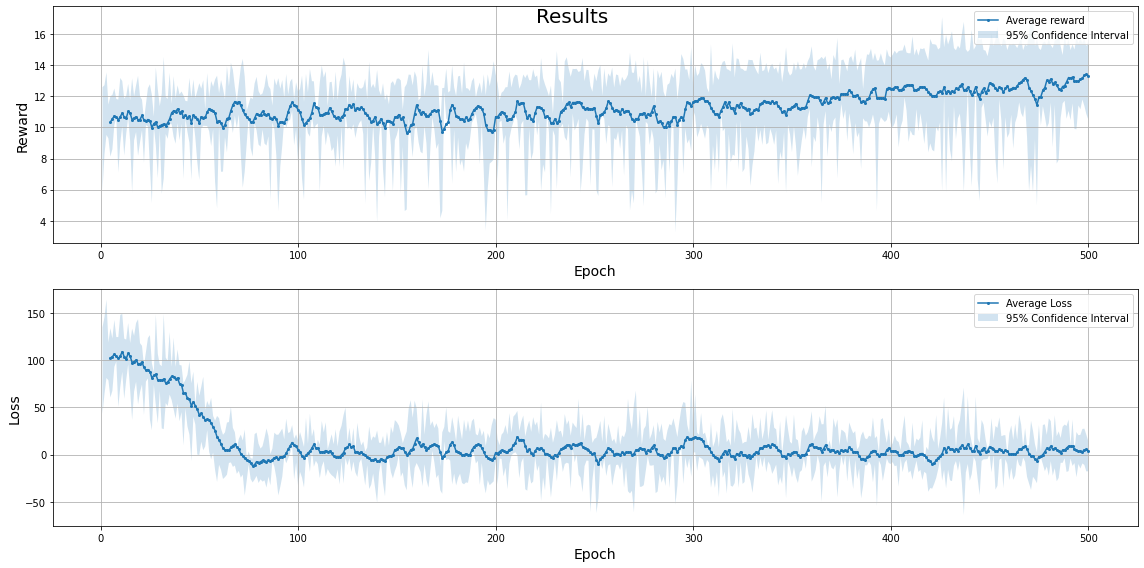

In [ ]:
plot_results(t_rewards,t_loss,5)

# Part Three

Training With Random Initialization

In [ ]:
model = policy_gradient(0.002,0.99,'highway-v0',0.002,'/content/drive/MyDrive/RL HW5/part_3/random_init/')

In [ ]:
t_rewards,t_loss = [],[]
for _ in range(5):
  model.reset()
  total_loss,total_reward = model.run (400,10)
  t_rewards.append(total_reward)
  t_loss.append(total_loss)
np.save(arr=t_rewards,file='/content/drive/MyDrive/RL HW5/part_3/random_init/arrays/rewards.npy')
np.save(arr=t_loss,file='/content/drive/MyDrive/RL HW5/part_3/random_init/arrays/loss.npy')

 12%|█▎        | 50/400 [03:11<20:59,  3.60s/it]

 Epoch 50 Sum Reward: 3.79 loss: -10.34


 25%|██▌       | 100/400 [06:43<20:14,  4.05s/it]

 Epoch 100 Sum Reward: 6.3 loss: 6.26


 38%|███▊      | 150/400 [10:19<18:57,  4.55s/it]

 Epoch 150 Sum Reward: 6.49 loss: 6.37


 50%|█████     | 200/400 [13:41<12:17,  3.69s/it]

 Epoch 200 Sum Reward: 6.06 loss: 3.91


 62%|██████▎   | 250/400 [17:30<12:46,  5.11s/it]

 Epoch 250 Sum Reward: 6.57 loss: 4.0


 75%|███████▌  | 300/400 [21:32<08:31,  5.12s/it]

 Epoch 300 Sum Reward: 6.86 loss: 1.83


 88%|████████▊ | 350/400 [25:45<04:02,  4.85s/it]

 Epoch 350 Sum Reward: 7.38 loss: 0.96


100%|██████████| 400/400 [29:45<00:00,  4.46s/it]


 Epoch 400 Sum Reward: 7.04 loss: 0.53


 12%|█▎        | 50/400 [03:38<26:01,  4.46s/it]

 Epoch 50 Sum Reward: 8.35 loss: 17.34


 25%|██▌       | 100/400 [07:31<24:37,  4.92s/it]

 Epoch 100 Sum Reward: 7.02 loss: 4.06


 38%|███▊      | 150/400 [11:30<15:18,  3.67s/it]

 Epoch 150 Sum Reward: 7.07 loss: -0.17


 50%|█████     | 200/400 [15:33<16:33,  4.97s/it]

 Epoch 200 Sum Reward: 7.33 loss: 2.46


 62%|██████▎   | 250/400 [19:34<12:11,  4.88s/it]

 Epoch 250 Sum Reward: 7.71 loss: 2.16


 75%|███████▌  | 300/400 [23:24<07:13,  4.33s/it]

 Epoch 300 Sum Reward: 7.35 loss: 3.63


 88%|████████▊ | 350/400 [27:01<02:58,  3.57s/it]

 Epoch 350 Sum Reward: 6.79 loss: 4.51


100%|██████████| 400/400 [30:54<00:00,  4.64s/it]


 Epoch 400 Sum Reward: 6.69 loss: 2.25


 12%|█▎        | 50/400 [03:42<27:29,  4.71s/it]

 Epoch 50 Sum Reward: 9.08 loss: 23.74


 25%|██▌       | 100/400 [07:16<20:24,  4.08s/it]

 Epoch 100 Sum Reward: 6.28 loss: 4.0


 38%|███▊      | 150/400 [11:06<21:04,  5.06s/it]

 Epoch 150 Sum Reward: 6.54 loss: 2.8


 50%|█████     | 200/400 [15:12<16:59,  5.10s/it]

 Epoch 200 Sum Reward: 6.9 loss: 2.08


 62%|██████▎   | 250/400 [19:11<12:43,  5.09s/it]

 Epoch 250 Sum Reward: 6.83 loss: 2.25


 75%|███████▌  | 300/400 [22:59<07:28,  4.49s/it]

 Epoch 300 Sum Reward: 6.58 loss: 1.84


 88%|████████▊ | 350/400 [26:45<03:52,  4.64s/it]

 Epoch 350 Sum Reward: 6.53 loss: 4.41


100%|██████████| 400/400 [30:39<00:00,  4.60s/it]


 Epoch 400 Sum Reward: 6.71 loss: 1.57


 12%|█▎        | 50/400 [03:32<22:36,  3.88s/it]

 Epoch 50 Sum Reward: 3.46 loss: -15.62


 25%|██▌       | 100/400 [06:58<15:43,  3.15s/it]

 Epoch 100 Sum Reward: 6.14 loss: 6.18


 38%|███▊      | 150/400 [10:25<18:48,  4.51s/it]

 Epoch 150 Sum Reward: 5.83 loss: 5.82


 50%|█████     | 200/400 [14:32<15:48,  4.74s/it]

 Epoch 200 Sum Reward: 7.14 loss: 0.99


 62%|██████▎   | 250/400 [18:48<12:43,  5.09s/it]

 Epoch 250 Sum Reward: 7.18 loss: 0.25


 75%|███████▌  | 300/400 [22:59<08:32,  5.12s/it]

 Epoch 300 Sum Reward: 6.96 loss: -0.02


 88%|████████▊ | 350/400 [27:13<04:18,  5.18s/it]

 Epoch 350 Sum Reward: 7.0 loss: 0.54


100%|██████████| 400/400 [31:25<00:00,  4.71s/it]


 Epoch 400 Sum Reward: 7.05 loss: 0.61


 12%|█▎        | 50/400 [03:39<23:11,  3.98s/it]

 Epoch 50 Sum Reward: 7.25 loss: 6.39


 25%|██▌       | 100/400 [07:31<23:35,  4.72s/it]

 Epoch 100 Sum Reward: 6.71 loss: 4.55


 38%|███▊      | 150/400 [11:24<19:52,  4.77s/it]

 Epoch 150 Sum Reward: 6.78 loss: 2.84


 50%|█████     | 200/400 [15:09<16:13,  4.87s/it]

 Epoch 200 Sum Reward: 6.47 loss: 2.51


 62%|██████▎   | 250/400 [19:25<13:10,  5.27s/it]

 Epoch 250 Sum Reward: 7.24 loss: 0.28


 75%|███████▌  | 300/400 [23:37<08:26,  5.06s/it]

 Epoch 300 Sum Reward: 6.96 loss: -0.42


 88%|████████▊ | 350/400 [27:51<03:33,  4.26s/it]

 Epoch 350 Sum Reward: 7.03 loss: 1.16


100%|██████████| 400/400 [31:58<00:00,  4.80s/it]

 Epoch 400 Sum Reward: 7.11 loss: 0.7


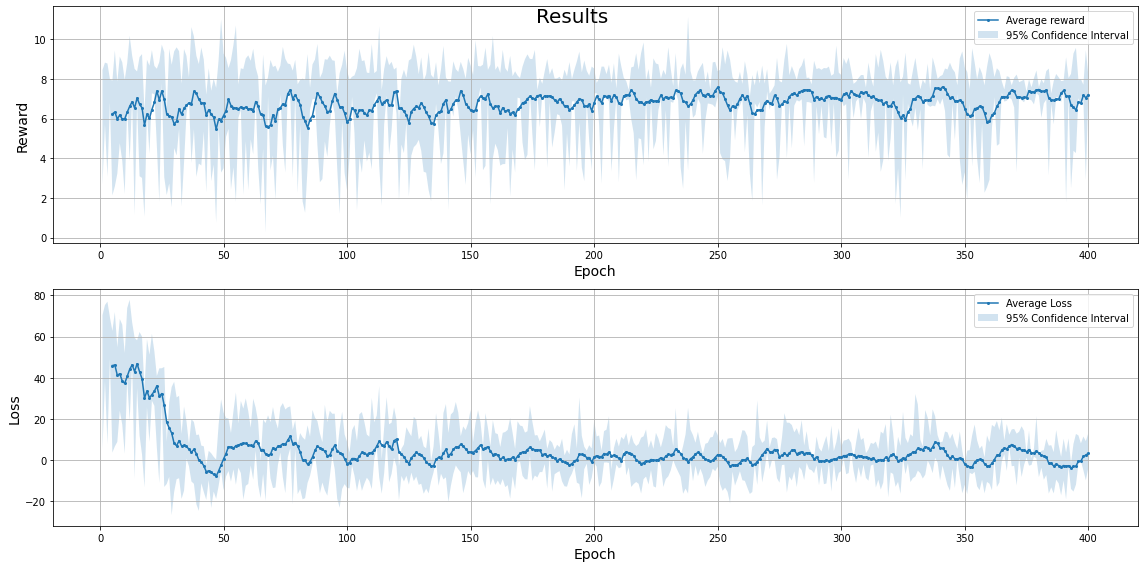

In [ ]:
plot_results(t_rewards,t_loss,5,400)

Training with Transfer Learning

In [7]:
model = policy_gradient(0.003,0.99,'highway-v0',0.001,'/content/drive/MyDrive/RL HW5/part_3/transfer_learning/')

In [8]:
model.load_weights('/content/drive/MyDrive/RL HW5/part_2/')

In [10]:
t_rewards,t_loss = [],[]
for _ in range(5):
  model.reset()
  total_loss,total_reward = model.run (400,10)
  t_rewards.append(total_reward)
  t_loss.append(total_loss)
np.save(arr=t_rewards,file='/content/drive/MyDrive/RL HW5/part_3/transfer_learning/arrays/rewards.npy')
np.save(arr=t_loss,file='/content/drive/MyDrive/RL HW5/part_3/transfer_learning/arrays/loss.npy')

 12%|█▎        | 50/400 [04:07<21:56,  3.76s/it]

 Epoch 50 Sum Reward: 2.53 loss: -6.6


 25%|██▌       | 100/400 [08:41<29:22,  5.88s/it]

 Epoch 100 Sum Reward: 6.82 loss: 2.51


 38%|███▊      | 150/400 [13:32<23:46,  5.71s/it]

 Epoch 150 Sum Reward: 7.08 loss: 0.78


 50%|█████     | 200/400 [18:06<18:15,  5.48s/it]

 Epoch 200 Sum Reward: 6.97 loss: 2.62


 62%|██████▎   | 250/400 [22:10<10:54,  4.36s/it]

 Epoch 250 Sum Reward: 6.39 loss: 4.58


 75%|███████▌  | 300/400 [26:41<08:01,  4.82s/it]

 Epoch 300 Sum Reward: 7.23 loss: 2.05


 88%|████████▊ | 350/400 [31:01<04:34,  5.49s/it]

 Epoch 350 Sum Reward: 6.71 loss: 2.49


100%|██████████| 400/400 [35:37<00:00,  5.34s/it]


 Epoch 400 Sum Reward: 7.05 loss: 0.96


 12%|█▎        | 50/400 [03:47<25:36,  4.39s/it]

 Epoch 50 Sum Reward: 4.42 loss: -11.9


 25%|██▌       | 100/400 [07:49<27:03,  5.41s/it]

 Epoch 100 Sum Reward: 6.55 loss: 4.41


 38%|███▊      | 150/400 [12:13<24:26,  5.87s/it]

 Epoch 150 Sum Reward: 7.14 loss: 1.69


 50%|█████     | 200/400 [16:11<17:37,  5.29s/it]

 Epoch 200 Sum Reward: 7.02 loss: 0.98


 62%|██████▎   | 250/400 [19:58<13:38,  5.45s/it]

 Epoch 250 Sum Reward: 6.45 loss: 2.56


 75%|███████▌  | 300/400 [24:48<09:15,  5.56s/it]

 Epoch 300 Sum Reward: 7.15 loss: 0.69


 88%|████████▊ | 350/400 [29:18<04:39,  5.58s/it]

 Epoch 350 Sum Reward: 6.96 loss: 1.92


100%|██████████| 400/400 [33:32<00:00,  5.03s/it]


 Epoch 400 Sum Reward: 6.64 loss: 3.77


 12%|█▎        | 50/400 [04:02<30:29,  5.23s/it]

 Epoch 50 Sum Reward: 7.63 loss: 26.8


 25%|██▌       | 100/400 [08:42<29:52,  5.98s/it]

 Epoch 100 Sum Reward: 6.88 loss: 4.96


 38%|███▊      | 150/400 [13:22<22:23,  5.38s/it]

 Epoch 150 Sum Reward: 7.01 loss: 0.18


 50%|█████     | 200/400 [17:30<17:08,  5.14s/it]

 Epoch 200 Sum Reward: 6.73 loss: -0.13


 62%|██████▎   | 250/400 [21:53<14:49,  5.93s/it]

 Epoch 250 Sum Reward: 7.21 loss: 0.44


 75%|███████▌  | 300/400 [26:18<07:58,  4.79s/it]

 Epoch 300 Sum Reward: 7.4 loss: -0.44


 88%|████████▊ | 350/400 [30:29<04:26,  5.34s/it]

 Epoch 350 Sum Reward: 6.97 loss: 0.0


100%|██████████| 400/400 [34:33<00:00,  5.18s/it]


 Epoch 400 Sum Reward: 6.76 loss: 0.0


 12%|█▎        | 50/400 [03:39<25:05,  4.30s/it]

 Epoch 50 Sum Reward: 7.07 loss: 3.45


 25%|██▌       | 100/400 [07:13<22:59,  4.60s/it]

 Epoch 100 Sum Reward: 6.34 loss: 0.79


 38%|███▊      | 150/400 [10:54<19:54,  4.78s/it]

 Epoch 150 Sum Reward: 6.62 loss: -0.39


 50%|█████     | 200/400 [14:34<15:17,  4.59s/it]

 Epoch 200 Sum Reward: 6.52 loss: -0.42


 62%|██████▎   | 250/400 [18:01<12:05,  4.84s/it]

 Epoch 250 Sum Reward: 6.02 loss: 0.0


 75%|███████▌  | 300/400 [21:47<08:32,  5.13s/it]

 Epoch 300 Sum Reward: 6.8 loss: 0.0


 88%|████████▊ | 350/400 [25:29<03:29,  4.19s/it]

 Epoch 350 Sum Reward: 6.78 loss: 0.0


100%|██████████| 400/400 [29:28<00:00,  4.42s/it]


 Epoch 400 Sum Reward: 7.29 loss: 0.0


 12%|█▎        | 50/400 [04:00<17:47,  3.05s/it]

 Epoch 50 Sum Reward: 1.82 loss: -9.89


 25%|██▌       | 100/400 [08:13<24:17,  4.86s/it]

 Epoch 100 Sum Reward: 6.73 loss: 4.67


 38%|███▊      | 150/400 [12:21<23:36,  5.67s/it]

 Epoch 150 Sum Reward: 6.49 loss: 4.54


 50%|█████     | 200/400 [16:28<16:36,  4.98s/it]

 Epoch 200 Sum Reward: 6.59 loss: -0.83


 62%|██████▎   | 250/400 [20:48<12:40,  5.07s/it]

 Epoch 250 Sum Reward: 6.91 loss: 0.5


 75%|███████▌  | 300/400 [25:20<09:35,  5.76s/it]

 Epoch 300 Sum Reward: 7.41 loss: -0.33


 88%|████████▊ | 350/400 [29:46<04:29,  5.39s/it]

 Epoch 350 Sum Reward: 7.23 loss: -0.35


100%|██████████| 400/400 [34:03<00:00,  5.11s/it]

 Epoch 400 Sum Reward: 6.92 loss: 0.0


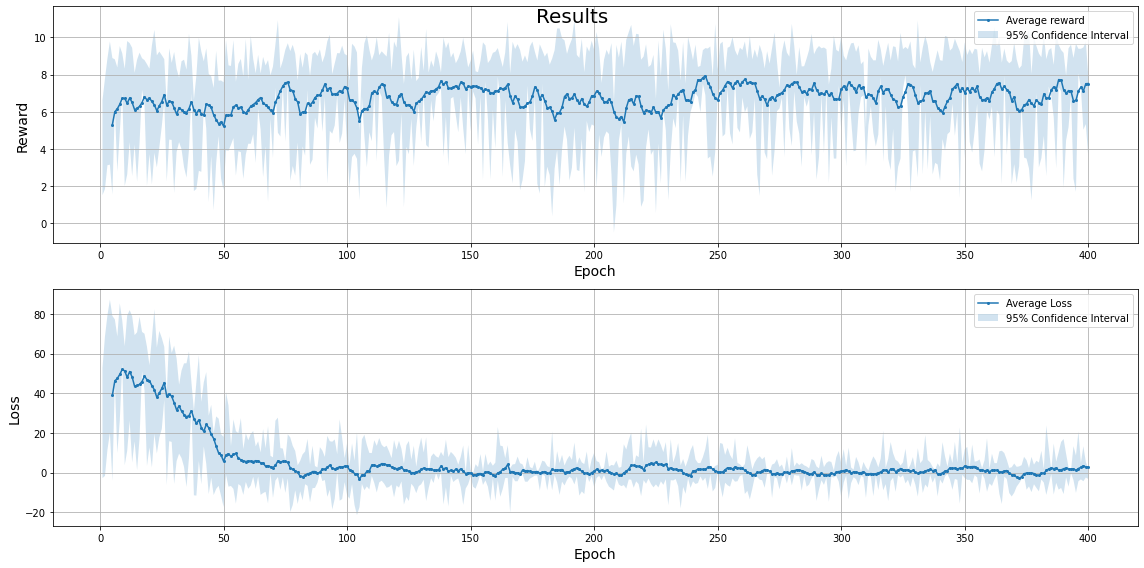

In [11]:
plot_results(t_rewards,t_loss,5,400)

# Part Four

Training Based on Image Observation

In [ ]:
class Policy_network(nn.Module):
    def __init__(self, observation_space_size: int, action_space_size: int):
        super(Policy_network, self).__init__()
        hidden_layer_size = 3360

        self.conv_net = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels=32,kernel_size = 4,stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(0,-1)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=hidden_layer_size, out_features=action_space_size, bias=True),
            nn.Softmax(dim=-1)
            
        )

    def forward(self, x):
        x = normalize(x)
        x = self.conv_net(x)
        x = self.fc(x)
        return x
class state_value(nn.Module):
    def __init__(self, observation_space_size: int):
        super(state_value, self).__init__()
        hidden_layer_size = 3360
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels=32,kernel_size = 4,stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(0,-1)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=hidden_layer_size, out_features=1, bias=True)
        )

    def forward(self, x):
        x = normalize(x)
        x = self.conv_net(x)
        x = self.fc(x)
        return x

In [ ]:
model = policy_gradient(0.0005,0.99,'merge-v0',0.0005,'/content/drive/MyDrive/RL HW5/part_4/')
model.env.config['observation'] = {'type': 'GrayscaleObservation', "observation_shape": (128, 64),"stack_size":3 ,"weights": [0.2989, 0.5870, 0.1140]}

In [ ]:
t_rewards,t_loss = [],[]
for _ in range(5):
  model.reset()
  total_loss,total_reward = model.run (500,30)
  t_rewards.append(total_reward)
  t_loss.append(total_loss)
np.save(arr=t_rewards,file='/content/drive/MyDrive/RL HW5/part_4/arrays/rewards.npy')
np.save(arr=t_loss,file='/content/drive/MyDrive/RL HW5/part_4/arrays/loss.npy')

 10%|█         | 50/500 [00:20<02:13,  3.36it/s]

 Epoch 50 Sum Reward: 4.72 loss: -31.25


 20%|██        | 100/500 [00:39<02:57,  2.26it/s]

 Epoch 100 Sum Reward: 11.5 loss: 8.88


 30%|███       | 150/500 [00:59<02:20,  2.50it/s]

 Epoch 150 Sum Reward: 11.93 loss: 9.92


 40%|████      | 200/500 [01:20<02:19,  2.15it/s]

 Epoch 200 Sum Reward: 13.17 loss: 2.27


 50%|█████     | 250/500 [01:44<01:58,  2.11it/s]

 Epoch 250 Sum Reward: 14.89 loss: -0.74


 60%|██████    | 300/500 [02:07<01:33,  2.13it/s]

 Epoch 300 Sum Reward: 14.89 loss: 0.47


 70%|███████   | 350/500 [02:31<01:09,  2.15it/s]

 Epoch 350 Sum Reward: 14.9 loss: 0.21


 80%|████████  | 400/500 [02:54<00:48,  2.07it/s]

 Epoch 400 Sum Reward: 14.9 loss: -1.07


 90%|█████████ | 450/500 [03:18<00:24,  2.08it/s]

 Epoch 450 Sum Reward: 14.9 loss: -0.43


100%|██████████| 500/500 [03:43<00:00,  2.24it/s]


 Epoch 500 Sum Reward: 14.89 loss: -0.18


 10%|█         | 50/500 [00:18<02:51,  2.62it/s]

 Epoch 50 Sum Reward: 13.17 loss: 34.34


 20%|██        | 101/500 [00:37<02:04,  3.20it/s]

 Epoch 100 Sum Reward: 11.23 loss: 5.05


 30%|███       | 150/500 [00:55<02:34,  2.27it/s]

 Epoch 150 Sum Reward: 10.97 loss: 12.37


 40%|████      | 200/500 [01:17<02:18,  2.17it/s]

 Epoch 200 Sum Reward: 14.08 loss: 3.11


 50%|█████     | 250/500 [01:40<01:50,  2.26it/s]

 Epoch 250 Sum Reward: 14.44 loss: 0.79


 60%|██████    | 300/500 [02:03<01:32,  2.16it/s]

 Epoch 300 Sum Reward: 14.6 loss: 0.92


 70%|███████   | 350/500 [02:25<01:08,  2.20it/s]

 Epoch 350 Sum Reward: 14.01 loss: -0.09


 80%|████████  | 400/500 [02:49<00:46,  2.13it/s]

 Epoch 400 Sum Reward: 14.64 loss: 0.19


 90%|█████████ | 450/500 [03:12<00:23,  2.13it/s]

 Epoch 450 Sum Reward: 14.78 loss: -0.76


100%|██████████| 500/500 [03:37<00:00,  2.30it/s]


 Epoch 500 Sum Reward: 14.87 loss: 0.1


 10%|█         | 50/500 [00:17<02:35,  2.90it/s]

 Epoch 50 Sum Reward: 8.22 loss: -13.38


 20%|██        | 100/500 [00:35<02:17,  2.91it/s]

 Epoch 100 Sum Reward: 10.91 loss: 3.99


 30%|███       | 150/500 [00:54<02:10,  2.68it/s]

 Epoch 150 Sum Reward: 10.91 loss: 1.22


 40%|████      | 200/500 [01:12<01:58,  2.53it/s]

 Epoch 200 Sum Reward: 11.32 loss: 1.59


 50%|█████     | 250/500 [01:33<01:39,  2.51it/s]

 Epoch 250 Sum Reward: 12.18 loss: 5.61


 60%|██████    | 300/500 [01:54<01:24,  2.36it/s]

 Epoch 300 Sum Reward: 12.35 loss: 3.7


 70%|███████   | 351/500 [02:14<00:51,  2.90it/s]

 Epoch 350 Sum Reward: 12.27 loss: 2.04


 80%|████████  | 400/500 [02:35<00:43,  2.28it/s]

 Epoch 400 Sum Reward: 12.4 loss: 2.2


 90%|█████████ | 450/500 [02:58<00:23,  2.15it/s]

 Epoch 450 Sum Reward: 14.23 loss: 2.59


100%|██████████| 500/500 [03:21<00:00,  2.48it/s]


 Epoch 500 Sum Reward: 14.58 loss: -1.4


 10%|█         | 50/500 [00:19<02:53,  2.59it/s]

 Epoch 50 Sum Reward: 11.39 loss: 11.19


 20%|██        | 100/500 [00:37<02:04,  3.22it/s]

 Epoch 100 Sum Reward: 10.96 loss: 7.54


 30%|███       | 150/500 [00:57<02:22,  2.45it/s]

 Epoch 150 Sum Reward: 11.99 loss: 6.56


 40%|████      | 200/500 [01:18<02:08,  2.33it/s]

 Epoch 200 Sum Reward: 13.01 loss: 6.5


 50%|█████     | 250/500 [01:41<01:56,  2.15it/s]

 Epoch 250 Sum Reward: 14.16 loss: -3.03


 60%|██████    | 300/500 [02:04<01:32,  2.16it/s]

 Epoch 300 Sum Reward: 14.89 loss: -0.75


 70%|███████   | 350/500 [02:27<01:09,  2.16it/s]

 Epoch 350 Sum Reward: 14.9 loss: -0.28


 80%|████████  | 400/500 [02:51<00:47,  2.12it/s]

 Epoch 400 Sum Reward: 14.92 loss: -1.68


 90%|█████████ | 450/500 [03:14<00:22,  2.18it/s]

 Epoch 450 Sum Reward: 14.92 loss: -0.0


100%|██████████| 500/500 [03:39<00:00,  2.28it/s]


 Epoch 500 Sum Reward: 14.92 loss: -0.0


 10%|█         | 50/500 [00:17<02:33,  2.93it/s]

 Epoch 50 Sum Reward: 10.7 loss: -2.11


 20%|██        | 100/500 [00:34<02:27,  2.71it/s]

 Epoch 100 Sum Reward: 10.2 loss: 1.6


 30%|███       | 150/500 [00:50<01:53,  3.09it/s]

 Epoch 150 Sum Reward: 10.07 loss: 1.72


 40%|████      | 200/500 [01:08<01:41,  2.94it/s]

 Epoch 200 Sum Reward: 10.42 loss: 4.81


 50%|█████     | 250/500 [01:25<01:24,  2.96it/s]

 Epoch 250 Sum Reward: 10.62 loss: -1.86


 60%|██████    | 300/500 [01:42<01:07,  2.96it/s]

 Epoch 300 Sum Reward: 10.7 loss: -0.38


 70%|███████   | 350/500 [01:59<00:51,  2.94it/s]

 Epoch 350 Sum Reward: 10.8 loss: 1.07


 80%|████████  | 400/500 [02:16<00:34,  2.93it/s]

 Epoch 400 Sum Reward: 10.83 loss: 0.41


 90%|█████████ | 450/500 [02:33<00:16,  3.01it/s]

 Epoch 450 Sum Reward: 10.87 loss: -0.11


100%|██████████| 500/500 [02:50<00:00,  2.94it/s]

 Epoch 500 Sum Reward: 10.92 loss: 0.76


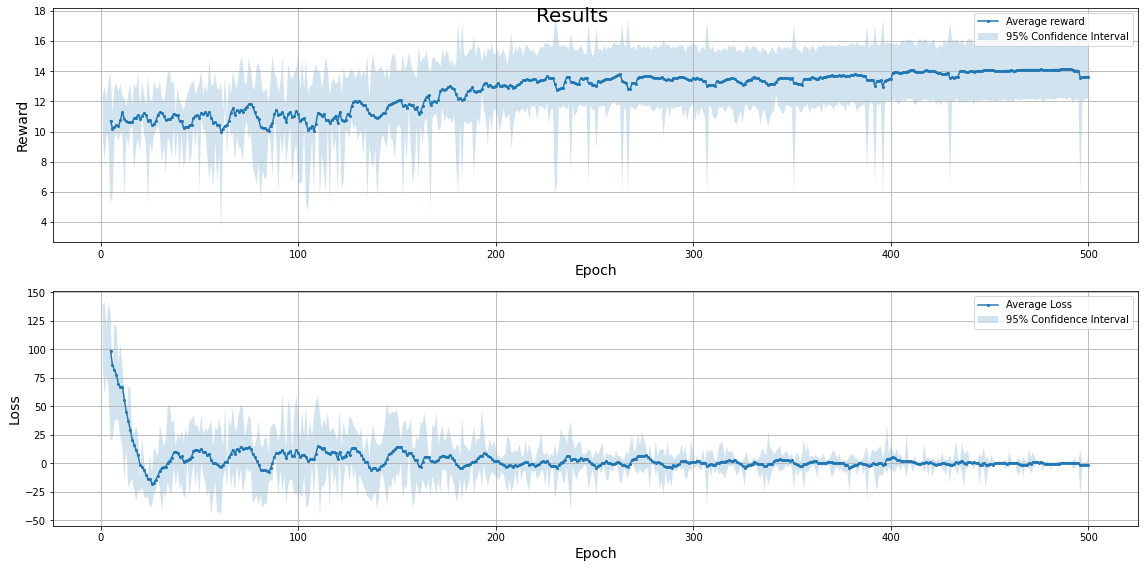

In [ ]:
plot_results(t_rewards,t_loss,5,500)

In [ ]:
rewards = np.load('/content/drive/MyDrive/RL HW5/part_4/arrays/rewards.npy',allow_pickle=True)
loss = np.load('/content/drive/MyDrive/RL HW5/part_4/arrays/loss.npy',allow_pickle=True)

rewards_2 = np.load('/content/drive/MyDrive/RL HW5/part_2/arrays/rewards.npy',allow_pickle=True)
loss_2 = np.load('/content/drive/MyDrive/RL HW5/part_2/arrays/loss.npy',allow_pickle=True)


In [ ]:

def plot_results(rewards,loss,rewards_2,loss_2,window_size,epochs):
    mean,lower_curve,upper_curve =confidence_interval(np.array(rewards).reshape(-1,epochs),window_size)
    mean_2,lower_curve_2,upper_curve_2 =confidence_interval(np.array(rewards_2).reshape(-1,epochs),window_size)
    fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(16,8),tight_layout=True)
    plt.suptitle("Results",size=20)
    axs[0].set_ylabel('Reward',size=14)
    axs[0].set_xlabel('Epoch',size=14)
    axs[0].grid()
    axs[0].fill_between(range(1,len(lower_curve)+1),lower_curve,upper_curve,alpha=0.2,label='95% Confidence Interval')
    axs[0].plot(range(window_size,len(mean)+window_size),mean,marker='o',markersize=2,label='Observation')
    axs[0].fill_between(range(1,len(lower_curve_2)+1),lower_curve_2,upper_curve_2,alpha=0.2,label='95% Confidence Interval')
    axs[0].plot(range(window_size,len(mean_2)+window_size),mean_2,marker='o',markersize=2,label='State')

    
    mean,lower_curve,upper_curve =confidence_interval(np.array(loss).reshape(-1,epochs),window_size)
    mean_2,lower_curve_2,upper_curve_2 =confidence_interval(np.array(loss_2).reshape(-1,epochs),window_size)
    axs[1].set_ylabel('Loss',size=14)
    axs[1].set_xlabel('Epoch',size=14)
    axs[1].grid()
    axs[1].fill_between(range(1,len(lower_curve)+1),lower_curve,upper_curve,alpha=0.2,label='95% Confidence Interval')
    axs[1].fill_between(range(1,len(lower_curve_2)+1),lower_curve_2,upper_curve_2,alpha=0.2,label='95% Confidence Interval')
    axs[1].plot(range(window_size,len(mean)+window_size),mean,marker='o',markersize=2,label='Observation')
    axs[1].plot(range(window_size,len(mean_2)+window_size),mean_2,marker='o',markersize=2,label='State')
    
    axs[0].legend()
    axs[1].legend()
    plt.show()

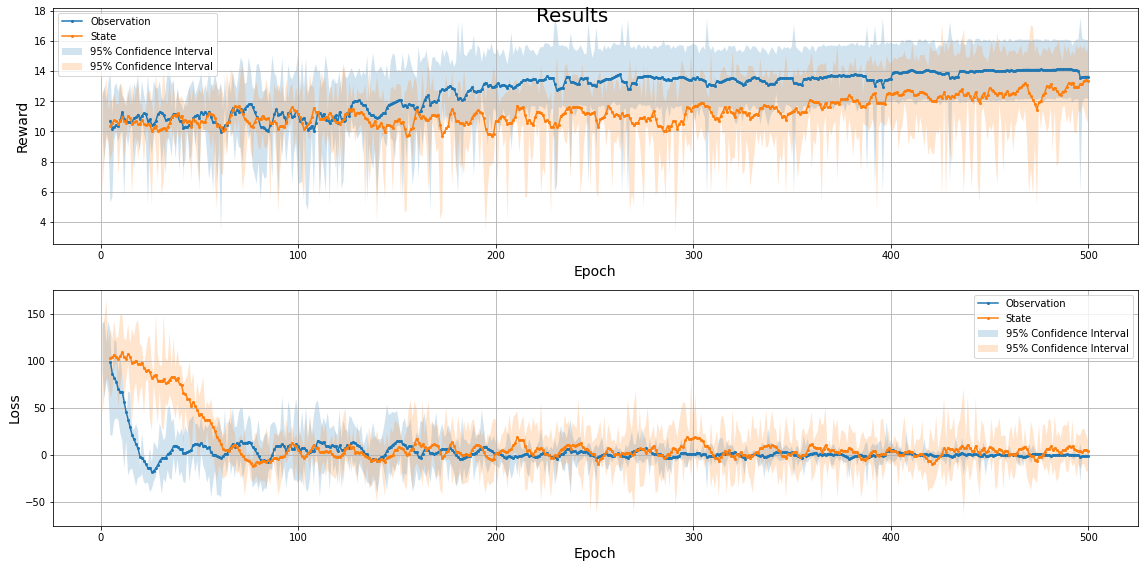

In [ ]:
plot_results(rewards,loss,rewards_2,loss_2,5,500)

Statistical Test:

In [ ]:
import scipy.stats as stats

In [ ]:
r1= np.array(rewards).reshape(-1,500)[:,-50:].flatten()

In [ ]:
r2=np.array(rewards_2).reshape(-1,500)[:,-50:].flatten()

$H_0$ :  $\mu_{2}$>=$\mu_{1}$ 

$H_a$: $\mu_2$<$\mu_1$ 

In [ ]:
t,p = stats.ttest_ind(a=r1, b=r2, equal_var=True)

In [ ]:
p

3.668525498642706e-11

In [ ]:
print(f'P value for One Sided T test: {p/2}')

P value for One Sided T test: 1.834262749321353e-11
